In [67]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS
import itertools

In [68]:
import pandas as pd
from stable_baselines3.common.logger import configure
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


In [82]:
#查看数据样例
aapl_df_finrl = YahooDownloader(start_date = '2020-01-01',
                                end_date = '2020-01-31',
                                ticker_list = ['aapl']).fetch_data()
aapl_df_finrl.head()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (20, 8)


,date,open,high,low,close,volume,tic,day
0,2020-01-02,74.059998,75.150002,73.797501,73.152634,135480400,aapl,3
1,2020-01-03,74.287498,75.144997,74.125000,72.441444,146322800,aapl,4
2,2020-01-06,73.447502,74.989998,73.187500,73.018692,118387200,aapl,0
3,2020-01-07,74.959999,75.224998,74.370003,72.675262,108872000,aapl,1
4,2020-01-08,74.290001,76.110001,74.290001,73.844360,132079200,aapl,2


In [70]:
#多股票选股
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [135]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-12-30'
TRADE_START_DATE = '2020-12-31'
TRADE_END_DATE = '2023-09-30'

In [136]:
#只选苹果数据
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['aapl']).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3711, 8)


In [6]:
#选30支股票数据
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [137]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.747390,746015200,aapl,4
1,2009-01-05,3.327500,3.435000,3.311071,2.863341,1181608400,aapl,0
2,2009-01-06,3.426786,3.470357,3.299643,2.816113,1289310400,aapl,1
3,2009-01-07,3.278929,3.303571,3.223571,2.755260,753048800,aapl,2
4,2009-01-08,3.229643,3.326786,3.215714,2.806425,673500800,aapl,3


In [138]:
#  INDICATORS = ['macd','rsi_30',]
INDICATORS = ['macd','boll_ub','boll_lb','rsi_30','cci_30','dx_30','close_30_sma','close_60_sma',]


In [139]:
#数据加入技术指标

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3710, 8)
Successfully added vix
Successfully added turbulence index


In [140]:
#合并df
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,aapl,3.067143,3.251429,3.041429,2.747390,7.460152e+08,4.0,0.000000,2.969345,2.641386,100.000000,66.666667,100.000000,2.747390,2.747390,39.189999,0.0
3,2009-01-05,aapl,3.327500,3.435000,3.311071,2.863341,1.181608e+09,0.0,0.002601,2.969345,2.641386,100.000000,66.666667,100.000000,2.805366,2.805366,39.080002,0.0
4,2009-01-06,aapl,3.426786,3.470357,3.299643,2.816113,1.289310e+09,1.0,0.001850,2.925562,2.692335,70.355466,46.865721,100.000000,2.808948,2.808948,38.560001,0.0
5,2009-01-07,aapl,3.278929,3.303571,3.223571,2.755260,7.530488e+08,2.0,-0.000734,2.904834,2.686219,50.428887,-29.677195,43.607834,2.795526,2.795526,43.389999,0.0
6,2009-01-08,aapl,3.229643,3.326786,3.215714,2.806425,6.735008e+08,3.0,-0.000087,2.892870,2.702542,60.226895,-9.098805,48.357918,2.797706,2.797706,42.560001,0.0


In [141]:
#分出训练和测试
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

3019
690


In [125]:
#以下为test选一只股票
df_rt = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['aapl']).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (691, 8)


In [126]:
processed_rt = fe.preprocess_data(df_rt)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (690, 8)
Successfully added vix
Successfully added turbulence index


In [127]:
list_ticker = processed_rt["tic"].unique().tolist()
list_date = list(pd.date_range(processed_rt['date'].min(),processed_rt['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))
processed_fullrt = pd.DataFrame(combination,columns=["date","tic"]).merge(processed_rt,on=["date","tic"],how="left")
processed_fullrt = processed_fullrt[processed_fullrt['date'].isin(processed_rt['date'])]
processed_fullrt = processed_fullrt.sort_values(['date','tic'])
processed_fullrt = processed_fullrt.fillna(0)
processed_fullrt.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-12-31,aapl,134.080002,134.740005,131.720001,130.387222,99116600.0,3.0,0.000000,133.333781,124.217611,0.000000,-66.666667,100.000000,130.387222,130.387222,22.750000,0.0
4,2021-01-04,aapl,133.520004,133.610001,126.760002,127.164169,143301900.0,0.0,-0.072312,133.333781,124.217611,0.000000,-66.666667,100.000000,128.775696,128.775696,26.969999,0.0
5,2021-01-05,aapl,128.889999,131.740005,128.429993,128.736389,97664900.0,1.0,-0.043386,131.985966,125.539221,33.538274,-38.070389,100.000000,128.762594,128.762594,25.340000,0.0
6,2021-01-06,aapl,127.720001,131.050003,126.379997,124.402916,155088000.0,2.0,-0.185624,132.765173,122.580176,17.143869,-113.056447,100.000000,127.672674,127.672674,25.070000,0.0
7,2021-01-07,aapl,128.360001,131.630005,127.860001,128.647964,109578200.0,3.0,-0.090087,132.363409,123.372055,44.591342,-10.133255,82.312548,127.867732,127.867732,22.370001,0.0


In [118]:
trade = data_split(processed_fullrt, TRADE_START_DATE,TRADE_END_DATE)
print(len(trade))
trade.to_csv('trade_data.csv')

691


In [142]:
check_and_make_directories([TRAINED_MODEL_DIR])


In [143]:
train = pd.read_csv('train_data.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

In [144]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [145]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,                    #最多交易股数
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4       #缩放reward
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [146]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [82]:
#a2c
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")
if if_using_a2c:
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  model_a2c.set_logger(new_logger_a2c)

trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c',total_timesteps=50000) if if_using_a2c else None
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c
---------------------------------------
| time/                 |             |
|    fps                | 1693        |
|    iterations         | 100         |
|    time_elapsed       | 0           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -1.55       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -0.00223    |
|    reward             | 0.001492326 |
|    std                | 1.14        |
|    value_loss         | 6.25e-06    |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 1675       |
|    iterations         | 200        |
|    time_elapsed       | 0          |
|    total_timesteps    | 1000       |
| train/                |   

-------------------------------------
| time/                 |           |
|    fps                | 1624      |
|    iterations         | 1500      |
|    time_elapsed       | 4         |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -1.61     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | -4.65     |
|    reward             | 1.7337857 |
|    std                | 1.2       |
|    value_loss         | 11.9      |
-------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 1624        |
|    iterations         | 1600        |
|    time_elapsed       | 4           |
|    total_timesteps    | 8000        |
| train/                |             |
|    entropy_loss       | -1.61       |
|    explained_variance | 5.96e-08    |
|    learning_rate      | 0.0007

--------------------------------------
| time/                 |            |
|    fps                | 1644       |
|    iterations         | 2800       |
|    time_elapsed       | 8          |
|    total_timesteps    | 14000      |
| train/                |            |
|    entropy_loss       | -1.89      |
|    explained_variance | -0.011     |
|    learning_rate      | 0.0007     |
|    n_updates          | 2799       |
|    policy_loss        | 0.777      |
|    reward             | -0.8469025 |
|    std                | 1.6        |
|    value_loss         | 0.529      |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1644      |
|    iterations         | 2900      |
|    time_elapsed       | 8         |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -1.88     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

---------------------------------------
| time/                 |             |
|    fps                | 1637        |
|    iterations         | 4200        |
|    time_elapsed       | 12          |
|    total_timesteps    | 21000       |
| train/                |             |
|    entropy_loss       | -2.01       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 4199        |
|    policy_loss        | -0.0237     |
|    reward             | 0.021542883 |
|    std                | 1.81        |
|    value_loss         | 0.000185    |
---------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 1637          |
|    iterations         | 4300          |
|    time_elapsed       | 13            |
|    total_timesteps    | 21500         |
| train/                |               |
|    entropy_loss       | -2.03         |
|    explained_variance 

day: 3018, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 1944387.03
total_reward: 944387.03
total_cost: 6163.51
total_trades: 2369
Sharpe: 0.602
-----------------------------------------
| time/                 |               |
|    fps                | 1644          |
|    iterations         | 5500          |
|    time_elapsed       | 16            |
|    total_timesteps    | 27500         |
| train/                |               |
|    entropy_loss       | -2.45         |
|    explained_variance | 1.19e-07      |
|    learning_rate      | 0.0007        |
|    n_updates          | 5499          |
|    policy_loss        | 0.0206        |
|    reward             | -0.0151214795 |
|    std                | 2.79          |
|    value_loss         | 0.000613      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 1646         |
|    iterations         | 5600         |
|    t

---------------------------------------
| time/                 |             |
|    fps                | 1662        |
|    iterations         | 6800        |
|    time_elapsed       | 20          |
|    total_timesteps    | 34000       |
| train/                |             |
|    entropy_loss       | -2.6        |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0007      |
|    n_updates          | 6799        |
|    policy_loss        | -0.00534    |
|    reward             | 0.021791404 |
|    std                | 3.26        |
|    value_loss         | 0.00488     |
---------------------------------------
---------------------------------------
| time/                 |             |
|    fps                | 1662        |
|    iterations         | 6900        |
|    time_elapsed       | 20          |
|    total_timesteps    | 34500       |
| train/                |             |
|    entropy_loss       | -2.61       |
|    explained_variance | 5.96e-08    |


---------------------------------------
| time/                 |             |
|    fps                | 1666        |
|    iterations         | 8100        |
|    time_elapsed       | 24          |
|    total_timesteps    | 40500       |
| train/                |             |
|    entropy_loss       | -2.86       |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 8099        |
|    policy_loss        | -0.445      |
|    reward             | -0.07380937 |
|    std                | 4.22        |
|    value_loss         | 0.0415      |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1667      |
|    iterations         | 8200      |
|    time_elapsed       | 24        |
|    total_timesteps    | 41000     |
| train/                |           |
|    entropy_loss       | -2.86     |
|    explained_variance | 0         |
|    learning_rate

-------------------------------------
| time/                 |           |
|    fps                | 1673      |
|    iterations         | 9500      |
|    time_elapsed       | 28        |
|    total_timesteps    | 47500     |
| train/                |           |
|    entropy_loss       | -2.91     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 9499      |
|    policy_loss        | -0.578    |
|    reward             | -6.662285 |
|    std                | 4.42      |
|    value_loss         | 0.352     |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 1674       |
|    iterations         | 9600       |
|    time_elapsed       | 28         |
|    total_timesteps    | 48000      |
| train/                |            |
|    entropy_loss       | -2.9       |
|    explained_variance | -0.00503   |
|    learning_rate      | 0.0007     |
| 

In [148]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
    "batch_size": 32,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
}
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 320        |
|    time_elapsed    | 37         |
|    total_timesteps | 12076      |
| train/             |            |
|    actor_loss      | 5.52e+03   |
|    critic_loss     | 2.89e+04   |
|    learning_rate   | 0.001      |
|    n_updates       | 9057       |
|    reward          | -17.702072 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 269        |
|    time_elapsed    | 89         |
|    total_timesteps | 24152      |
| train/             |            |
|    actor_loss      | 2.79e+03   |
|    critic_loss     | 851        |
|    learning_rate   | 0.001      |
|    n_updates       | 21133      |
|    reward          | -17.70

In [84]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo
------------------------------------
| time/              |             |
|    fps             | 2878        |
|    iterations      | 1           |
|    time_elapsed    | 0           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | 0.015556279 |
------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2531         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0037344233 |
|    clip_fraction        | 0.0367       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0            |
|    learning_rate        | 0.

------------------------------------------
| time/                   |              |
|    fps                  | 2226         |
|    iterations           | 11           |
|    time_elapsed         | 10           |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0052929893 |
|    clip_fraction        | 0.0196       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | -1.55e-06    |
|    learning_rate        | 0.00025      |
|    loss                 | 1.13         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00173     |
|    reward               | -0.22820558  |
|    std                  | 0.99         |
|    value_loss           | 2.52         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 2229          |
|    ite

day: 3018, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 6736794.57
total_reward: 5736794.57
total_cost: 5536.93
total_trades: 3002
Sharpe: 0.903
------------------------------------------
| time/                   |              |
|    fps                  | 2233         |
|    iterations           | 21           |
|    time_elapsed         | 19           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0010904435 |
|    clip_fraction        | 0.00151      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.567        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.4         |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00132     |
|    reward               | -0.09357748  |
|    std                  | 0.991        |
|    value_loss           | 112          |
------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 2234         |
|    iterations           | 31           |
|    time_elapsed         | 28           |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0007011441 |
|    clip_fraction        | 0.00928      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.635        |
|    learning_rate        | 0.00025      |
|    loss                 | 101          |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00151     |
|    reward               | -0.03678761  |
|    std                  | 1.01         |
|    value_loss           | 262          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2235         |
|    iterat

-----------------------------------------
| time/                   |             |
|    fps                  | 2248        |
|    iterations           | 41          |
|    time_elapsed         | 37          |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.001509803 |
|    clip_fraction        | 0.0143      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.363       |
|    learning_rate        | 0.00025     |
|    loss                 | 297         |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.000519    |
|    reward               | 5.6424437   |
|    std                  | 1.02        |
|    value_loss           | 557         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2249         |
|    iterations           | 42 

day: 3018, episode: 70
begin_total_asset: 1000000.00
end_total_asset: 11497014.45
total_reward: 10497014.45
total_cost: 3906.10
total_trades: 3007
Sharpe: 0.981
------------------------------------------
| time/                   |              |
|    fps                  | 2248         |
|    iterations           | 51           |
|    time_elapsed         | 46           |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0038284305 |
|    clip_fraction        | 0.0183       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.46        |
|    explained_variance   | 0.623        |
|    learning_rate        | 0.00025      |
|    loss                 | 97.5         |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.00146     |
|    reward               | 0.41462392   |
|    std                  | 1.04         |
|    value_loss           | 197          |
----------------------

------------------------------------------
| time/                   |              |
|    fps                  | 2258         |
|    iterations           | 61           |
|    time_elapsed         | 55           |
|    total_timesteps      | 124928       |
| train/                  |              |
|    approx_kl            | 0.0045396546 |
|    clip_fraction        | 0.0175       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.44        |
|    explained_variance   | 0.901        |
|    learning_rate        | 0.00025      |
|    loss                 | 26.7         |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.00133     |
|    reward               | 1.4737114    |
|    std                  | 1.02         |
|    value_loss           | 44.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2259         |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 2259         |
|    iterations           | 71           |
|    time_elapsed         | 64           |
|    total_timesteps      | 145408       |
| train/                  |              |
|    approx_kl            | 0.0046009086 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.534        |
|    learning_rate        | 0.00025      |
|    loss                 | 286          |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.00338     |
|    reward               | 0.18006095   |
|    std                  | 1.01         |
|    value_loss           | 531          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2260         |
|    iterat

------------------------------------------
| time/                   |              |
|    fps                  | 2267         |
|    iterations           | 81           |
|    time_elapsed         | 73           |
|    total_timesteps      | 165888       |
| train/                  |              |
|    approx_kl            | 0.0008520384 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.508        |
|    learning_rate        | 0.00025      |
|    loss                 | 243          |
|    n_updates            | 800          |
|    policy_gradient_loss | 0.000101     |
|    reward               | 16.176058    |
|    std                  | 1.01         |
|    value_loss           | 587          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2268        |
|    iteration

-----------------------------------------
| time/                   |             |
|    fps                  | 2272        |
|    iterations           | 91          |
|    time_elapsed         | 82          |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.005231878 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.216       |
|    learning_rate        | 0.00025     |
|    loss                 | 489         |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.00181    |
|    reward               | 1.4176114   |
|    std                  | 1.02        |
|    value_loss           | 684         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2273         |
|    iterations           | 92 

In [149]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 128, 
              "buffer_size": 1000000, 
              "learning_rate": 0.0005}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0005}
Using cpu device
Logging to results/td3
day: 3018, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 8425002.76
total_reward: 7425002.76
total_cost: 8729.48
total_trades: 3007
Sharpe: 0.983
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 316        |
|    time_elapsed    | 38         |
|    total_timesteps | 12076      |
| train/             |            |
|    actor_loss      | -2.29e+03  |
|    critic_loss     | 1.74e+05   |
|    learning_rate   | 0.0005     |
|    n_updates       | 9057       |
|    reward          | -17.702072 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 242        |
|    time_elapsed    | 99         |
|    total_timesteps | 24152      |
| train/             |            |
|    actor_l

In [156]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 64,
    "buffer_size": 200000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

{'batch_size': 64, 'buffer_size': 200000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 220        |
|    time_elapsed    | 54         |
|    total_timesteps | 12076      |
| train/             |            |
|    actor_loss      | 7.25e+03   |
|    critic_loss     | 734        |
|    ent_coef        | 3.63       |
|    ent_coef_loss   | -41.1      |
|    learning_rate   | 0.0003     |
|    n_updates       | 11975      |
|    reward          | -17.702072 |
-----------------------------------
day: 3018, episode: 90
begin_total_asset: 1000000.00
end_total_asset: 13117625.03
total_reward: 12117625.03
total_cost: 999.00
total_trades: 3018
Sharpe: 0.984
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 221        |
|

In [87]:
%matplotlib inline

In [157]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [158]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [159]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

In [160]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [161]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [93]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)
print( df_account_value_a2c.tail())

hit end!
           date  account_value
685  2023-09-22   1.363693e+06
686  2023-09-25   1.373609e+06
687  2023-09-26   1.341453e+06
688  2023-09-27   1.329653e+06
689  2023-09-28   1.331665e+06


In [94]:
pd.options.display.max_rows= None
print(f"df_actions.head(): {df_actions_a2c}")

df_actions.head():            date actions
0    2020-12-31   [100]
1    2021-01-04   [100]
2    2021-01-05   [100]
3    2021-01-06   [100]
4    2021-01-07   [100]
5    2021-01-08   [100]
6    2021-01-11   [100]
7    2021-01-12   [100]
8    2021-01-13   [100]
9    2021-01-14   [100]
10   2021-01-15   [100]
11   2021-01-19   [100]
12   2021-01-20   [100]
13   2021-01-21   [100]
14   2021-01-22   [100]
15   2021-01-25   [100]
16   2021-01-26   [100]
17   2021-01-27   [100]
18   2021-01-28   [100]
19   2021-01-29   [100]
20   2021-02-01   [100]
21   2021-02-02   [100]
22   2021-02-03   [100]
23   2021-02-04   [100]
24   2021-02-05   [100]
25   2021-02-08   [100]
26   2021-02-09   [100]
27   2021-02-10   [100]
28   2021-02-11   [100]
29   2021-02-12   [100]
30   2021-02-16   [100]
31   2021-02-17   [100]
32   2021-02-18   [100]
33   2021-02-19   [100]
34   2021-02-22   [100]
35   2021-02-23   [100]
36   2021-02-24   [100]
37   2021-02-25   [100]
38   2021-02-26   [100]
39   2021-03-01   [10

In [118]:
print("模型数据")

stats = backtest_stats(df_account_value_a2c, value_col_name = 'account_value')

模型数据
Annual return          0.110277
Cumulative returns     0.331665
Annual volatility      0.270722
Sharpe ratio           0.522038
Calmar ratio           0.356930
Stability              0.440602
Max drawdown          -0.308958
Omega ratio            1.093207
Sortino ratio          0.758854
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970897
Daily value at risk   -0.033547
dtype: float64


In [162]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [163]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [164]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


In [165]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


In [100]:
print("苹果股票数据")
df_aapl_ = get_baseline(
        ticker="aapl", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_aapl_, value_col_name = 'close')

苹果股票数据
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (691, 8)
Annual return          0.103906
Cumulative returns     0.311361
Annual volatility      0.286759
Sharpe ratio           0.488288
Calmar ratio           0.336125
Stability              0.439684
Max drawdown          -0.309128
Omega ratio            1.085225
Sortino ratio          0.708783
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.940023
Daily value at risk   -0.035573
dtype: float64


In [101]:
df_appl = YahooDownloader(start_date = TRADE_START_DATE,
                                end_date = TRADE_END_DATE,
                                ticker_list = ['aapl']).fetch_data()
df_appl.head()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (691, 8)


,date,open,high,low,close,volume,tic,day
0,2020-12-31,134.080002,134.740005,131.720001,130.387238,99116600,aapl,3
1,2021-01-04,133.520004,133.610001,126.760002,127.164162,143301900,aapl,0
2,2021-01-05,128.889999,131.740005,128.429993,128.736374,97664900,aapl,1
3,2021-01-06,127.720001,131.050003,126.379997,124.402939,155088000,aapl,2
4,2021-01-07,128.360001,131.630005,127.860001,128.647949,109578200,aapl,3


In [102]:
#为计算长期持有苹果收益做准备
df_appl = df_appl[["date", "close"]]
fst_day = df_appl["close"][0]
appl = pd.merge(
    df_appl["date"],
    df_appl["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")
df_appl.head()

,date,close
0,2020-12-31,130.387238
1,2021-01-04,127.164162
2,2021-01-05,128.736374
3,2021-01-06,124.402939
4,2021-01-07,128.647949


In [103]:
print("纳斯达克100")
df_ndx_ = get_baseline(
        ticker="^NDX", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)

stats = backtest_stats(df_ndx_, value_col_name = 'close')

纳斯达克100
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (691, 8)
Annual return          0.049533
Cumulative returns     0.141754
Annual volatility      0.246766
Sharpe ratio           0.319532
Calmar ratio           0.139281
Stability              0.039218
Max drawdown          -0.355631
Omega ratio            1.054667
Sortino ratio          0.452845
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.952347
Daily value at risk   -0.030777
dtype: float64


In [104]:
df_ndx = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["^ndx"]
).fetch_data()
df_ndx.head()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (691, 8)


,date,open,high,low,close,volume,tic,day
0,2020-12-31,12852.959961,12904.089844,12804.750000,12888.280273,4815840000,^ndx,3
1,2021-01-04,12950.219727,12950.219727,12537.419922,12694.660156,6636170000,^ndx,0
2,2021-01-05,12663.129883,12809.669922,12663.129883,12802.379883,6971860000,^ndx,1
3,2021-01-06,12601.259766,12803.290039,12569.419922,12623.349609,7689880000,^ndx,2
4,2021-01-07,12745.410156,12966.679688,12744.820312,12939.570312,6841480000,^ndx,3


In [105]:
#纳斯达克100长期持有
df_ndx = df_ndx[["date", "close"]]
fst_day = df_ndx["close"][0]
ndx = pd.merge(
    df_ndx["date"],
    df_ndx["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

In [35]:
df_ndx.head()

,date,close
0,2020-12-31,12888.280273
1,2021-01-04,12694.660156
2,2021-01-05,12802.379883
3,2021-01-06,12623.349609
4,2021-01-07,12939.570312


In [166]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
df_result_td3 = (
    df_account_value_td3.set_index(df_account_value_td3.columns[0])
    if if_using_td3
    else None
)
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
    if if_using_sac
    else None
)

result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "td3": df_result_td3["account_value"] if if_using_td3 else None,
        "sac": df_result_sac["account_value"] if if_using_sac else None,
        "appl": appl["close"],
        "ndx": ndx["close"],
    }
)

In [170]:
result.tail()


,a2c,ddpg,ppo,td3,sac,appl,ndx
date,,,,,,,
2023-09-25,1.373609e+06,1.383763e+06,1.383763e+06,1.383763e+06,1.383763e+06,1.348662e+06,1.145917e+06
2023-09-26,1.341453e+06,1.351385e+06,1.351385e+06,1.351385e+06,1.351385e+06,1.317106e+06,1.128609e+06
2023-09-27,1.329653e+06,1.339361e+06,1.339361e+06,1.339361e+06,1.339361e+06,1.305387e+06,1.131273e+06
2023-09-28,1.331665e+06,1.341405e+06,1.341405e+06,1.341405e+06,1.341405e+06,1.307378e+06,1.140786e+06
2023-09-29,NaN,NaN,NaN,NaN,NaN,1.311361e+06,1.141754e+06


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

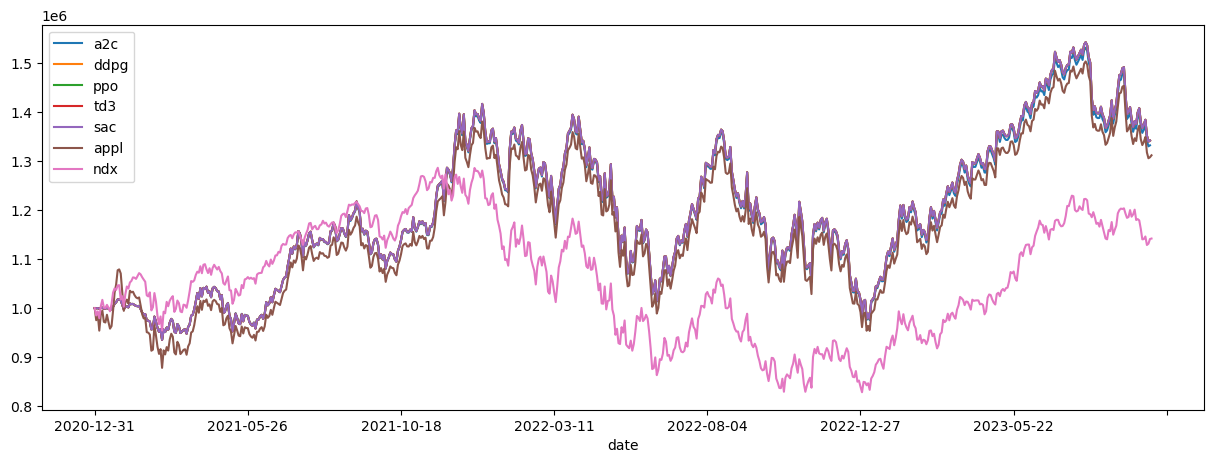

In [168]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

In [416]:
#以下用于前端输出
YEAR=2023
MONTH=11
DAY=15

In [417]:
LAST_TD=str(YEAR)+'-'+str(MONTH)+'-'+str(DAY)
NEXT='2080-01-01'

In [418]:
df_prd = YahooDownloader(start_date = '2023-09-13',
                     end_date = NEXT,
                     ticker_list = ['aapl']).fetch_data()
df_prd

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (46, 8)


,date,open,high,low,close,volume,tic,day
0,2023-09-13,176.509995,177.300003,173.979996,173.980789,84267900,aapl,2
1,2023-09-14,174.000000,176.100006,173.580002,175.508789,60895800,aapl,3
2,2023-09-15,176.479996,176.500000,173.820007,174.779724,109205100,aapl,4
3,2023-09-18,176.479996,179.380005,176.169998,177.735840,67257600,aapl,0
4,2023-09-19,177.520004,179.630005,177.130005,178.834396,51826900,aapl,1
5,2023-09-20,179.259995,179.699997,175.399994,175.259109,58436200,aapl,2
6,2023-09-21,174.550003,176.300003,173.860001,173.701157,63047900,aapl,3
7,2023-09-22,174.669998,177.080002,174.050003,174.560013,56725400,aapl,4
8,2023-09-25,174.199997,176.970001,174.149994,175.848328,46172700,aapl,0
9,2023-09-26,174.820007,175.199997,171.660004,171.733749,64588900,aapl,1


In [419]:

processed = fe.preprocess_data(df_prd)

Successfully added technical indicators


In [420]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)
processed_full.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30
57,2023-11-09,aapl,182.960007,184.119995,181.809998,182.169998,53763500.0,3.0,1.479625,59.919636
58,2023-11-10,aapl,183.970001,186.570007,183.529999,186.399994,66133400.0,4.0,2.057820,64.145860
61,2023-11-13,aapl,185.820007,186.029999,184.210007,184.800003,43627500.0,0.0,2.363326,61.604118
62,2023-11-14,aapl,187.699997,188.110001,186.300003,187.440002,60108400.0,1.0,2.779982,64.036513
63,2023-11-15,aapl,187.850006,189.500000,187.779999,188.009995,53666800.0,2.0,3.118688,64.538275


In [421]:
processed_full.loc[processed_full.index.max()+1]=processed_full.iloc[-1]
processed_full.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30
58,2023-11-10,aapl,183.970001,186.570007,183.529999,186.399994,66133400.0,4.0,2.057820,64.145860
61,2023-11-13,aapl,185.820007,186.029999,184.210007,184.800003,43627500.0,0.0,2.363326,61.604118
62,2023-11-14,aapl,187.699997,188.110001,186.300003,187.440002,60108400.0,1.0,2.779982,64.036513
63,2023-11-15,aapl,187.850006,189.500000,187.779999,188.009995,53666800.0,2.0,3.118688,64.538275
64,2023-11-15,aapl,187.850006,189.500000,187.779999,188.009995,53666800.0,2.0,3.118688,64.538275


In [422]:
processed_full.iloc[-1,0]=NEXT
processed_full.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30
58,2023-11-10,aapl,183.970001,186.570007,183.529999,186.399994,66133400.0,4.0,2.057820,64.145860
61,2023-11-13,aapl,185.820007,186.029999,184.210007,184.800003,43627500.0,0.0,2.363326,61.604118
62,2023-11-14,aapl,187.699997,188.110001,186.300003,187.440002,60108400.0,1.0,2.779982,64.036513
63,2023-11-15,aapl,187.850006,189.500000,187.779999,188.009995,53666800.0,2.0,3.118688,64.538275
64,2080-01-01,aapl,187.850006,189.500000,187.779999,188.009995,53666800.0,2.0,3.118688,64.538275


In [423]:

trade = data_split(processed_full, LAST_TD,'2100-1-1')
print(len(trade))
trade.to_csv('trade_data.csv')

2


In [424]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = None,risk_indicator_col=None, **env_kwargs)

In [425]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [426]:
df_actions_a2c

,date,actions
0,2023-11-15,[100]


In [427]:
print(df_actions_a2c.iloc[0,1][0])

100
